<a href="https://colab.research.google.com/github/sara-aiminds/image_classifier_vgg/blob/main/image_classifier_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [5]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [7]:
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/

In [60]:
import shutil
import random
import math
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [21]:
#! kaggle competitions download <name-of-competition>
#Here, the name of the competition is not the bold title displayed over the background. It is the slug of the competition link followed after the “/c/”. Consider our example link:
#“https://www.kaggle.com/c/google-smartphone-decimeter-challenge”
#“google-smartphone-decimeter-challenge” is the name of the competition to be passed in the Kaggle command.

# ! kaggle datasets download <name-of-dataset>
# Here, the name of the dataset is the “user-name/dataset-name”. You can simply copy the trailing text after “www.kaggle.com/”. Therefore, in our case,
# “https://www.kaggle.com/arenagrenade/the-complete-pokemon-images-data-set”
# It will be: “arenagrenade/the-complete-pokemon-images-data-set”

! kaggle datasets download drgfreeman/rockpaperscissors
# https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

 95% 291M/306M [00:01<00:00, 162MB/s]
100% 306M/306M [00:01<00:00, 171MB/s]


In [36]:
!pwd
shutil.rmtree('/content/img_classifier_vgg')

/content


In [37]:
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./rockpaperscissors.zip
./.config/config_sentinel
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/gce
./.config/.last_update_check.json
./.config/.last_opt_in_prompt.yaml
./.config/configurations/config_default
./.config/logs/2022.11.14/14.31.28.787638.log
./.config/logs/2022.11.14/14.32.01.947102.log
./.config/logs/2022.11.14/14.32.01.122641.log
./.config/logs/2022.11.14/14.30.40.117899.log
./.config/logs/2022.11.14/14.31.06.056791.log
./.config/logs/2022.11.14/14.31.37.937258.log
./gdrive/MyDrive/kaggle.json


In [38]:
os.makedirs('/content/img_classifier_vgg')

!unzip rockpaperscissors.zip -d /content/img_classifier_vgg/input


Archive:  rockpaperscissors.zip
  inflating: /content/img_classifier_vgg/input/README_rpc-cv-images.txt  
  inflating: /content/img_classifier_vgg/input/paper/04l5I8TqdzF9WDMJ.png  
  inflating: /content/img_classifier_vgg/input/paper/0Og76sl5CJhbxWWx.png  
  inflating: /content/img_classifier_vgg/input/paper/0RA9rcrv8iVvuDDU.png  
  inflating: /content/img_classifier_vgg/input/paper/0Uomd0HvOB33m47I.png  
  inflating: /content/img_classifier_vgg/input/paper/0a3UtNzl5Ll3sq8K.png  
  inflating: /content/img_classifier_vgg/input/paper/0cb6cVL8pkfi4wF6.png  
  inflating: /content/img_classifier_vgg/input/paper/0eqArS2GgsBeqgSn.png  
  inflating: /content/img_classifier_vgg/input/paper/0t08v9bAaA0mXGCQ.png  
  inflating: /content/img_classifier_vgg/input/paper/0vugygEjxQJPr9yz.png  
  inflating: /content/img_classifier_vgg/input/paper/0zKU6wEhT2cDe9j0.png  
  inflating: /content/img_classifier_vgg/input/paper/14K62H4KG1hg5qiJ.png  
  inflating: /content/img_classifier_vgg/input/paper/1Dfw5

In [39]:
os.makedirs('/content/img_classifier_vgg/output/train')
os.makedirs('/content/img_classifier_vgg/output/val')
os.makedirs('/content/img_classifier_vgg/output/test')
os.listdir('/content/img_classifier_vgg/output')

['val', 'test', 'train']

In [42]:
os.listdir('/content/img_classifier_vgg/')

root_dir = '/content/img_classifier_vgg/'
folder1 = 'input'
folder2 = 'rockpaperscissors/rps-cv-images'
classes = ['rock', 'paper', 'scissors']

In [43]:
for clss in classes:
    print('------------' + clss + '-------------')
    dirtry = root_dir + '/' + folder1 + '/' + clss
    print(dirtry)
    files = os.listdir(dirtry)
    np.random.shuffle(files)
    
    print(len(files))

    base_dir = '/content/img_classifier_vgg/output'
    
    for folder in ['train','val','test']:
        target_dir = base_dir + '/' + folder
        os.makedirs(target_dir + '/' + clss)
        target_class = target_dir + '/' + clss
        print(target_class,os.listdir(target_dir))

        if folder == 'train':
            print('folder',folder,target_class)
            images_to_pass = files[: math.floor(0.8*len(files))]
            print('imgs in ',folder,' and ', target_class, '::', len(images_to_pass))
            for img in images_to_pass:
                img = dirtry + '/' + img
                shutil.copy(img, target_class)
        elif folder == 'val':
            print('folder',folder,target_class)
            images_to_pass = files[math.floor(0.8*len(files)) : math.floor(0.9*len(files))]
            print('imgs in ',folder,' and ', target_class, '::', len(images_to_pass))
            for img in images_to_pass:
                img = dirtry + '/' + img
                shutil.copy(img, target_class)
        else:
            print('folder',folder,target_class)
            images_to_pass = files[math.floor(0.9*len(files)):]
            print('imgs in ',folder,' and ', target_class, '::', len(images_to_pass))
            for img in images_to_pass:
                img = dirtry + '/' + img
                shutil.copy(img, target_class)
    
    
val_sum = 0
for res1 in os.listdir('/content/img_classifier_vgg/output/val'):
    link1 = '/content/img_classifier_vgg/output/val/' + res1
    val_sum += len(os.listdir(link1))
    
train_sum = 0
for res2 in os.listdir('/content/img_classifier_vgg/output/train'):
    link2 = '/content/img_classifier_vgg/output/train/' + res2
    train_sum += len(os.listdir(link2))
    
test_sum = 0
for res in os.listdir('/content/img_classifier_vgg/output/test'):
    link = '/content/img_classifier_vgg/output/test/' + res
    test_sum += len(os.listdir(link))
    
print(train_sum, val_sum, test_sum)

------------rock-------------
/content/img_classifier_vgg//input/rock
726
./output/train/rock ['rock']
folder train ./output/train/rock
imgs in  train  and  ./output/train/rock :: 580
./output/val/rock ['rock']
folder val ./output/val/rock
imgs in  val  and  ./output/val/rock :: 73
./output/test/rock ['rock']
folder test ./output/test/rock
imgs in  test  and  ./output/test/rock :: 73
------------paper-------------
/content/img_classifier_vgg//input/paper
712
./output/train/paper ['rock', 'paper']
folder train ./output/train/paper
imgs in  train  and  ./output/train/paper :: 569
./output/val/paper ['rock', 'paper']
folder val ./output/val/paper
imgs in  val  and  ./output/val/paper :: 71
./output/test/paper ['rock', 'paper']
folder test ./output/test/paper
imgs in  test  and  ./output/test/paper :: 72
------------scissors-------------
/content/img_classifier_vgg//input/scissors
750
./output/train/scissors ['scissors', 'rock', 'paper']
folder train ./output/train/scissors
imgs in  train 

In [44]:
train_path = '/content/img_classifier_vgg/output/train'
val_path = '/content/img_classifier_vgg/output/val'
test_path = '/content/img_classifier_vgg/output/test'

In [45]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)
        
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)
        
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [46]:
train_x=np.array(x_train)
val_x=np.array(x_val)
test_x=np.array(x_test)

In [47]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [48]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1749 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


In [49]:
train_y=training_set.classes
val_y=val_set.classes
test_y=test_set.classes

In [50]:
training_set.class_indices, val_set.class_indices, test_set.class_indices
train_y.shape, val_y.shape, test_y.shape

((1749,), (219,), (220,))

In [51]:
IMAGE_SIZE = [224,224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 1s 0us/step


In [52]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [53]:
x = Flatten()(vgg.output)

In [54]:
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [55]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [57]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
55/55 [==============================] - 1333s 24s/step - loss: 3.1687 - accuracy: 0.8651 - val_loss: 2.5194 - val_accuracy: 0.8950
Epoch 2/10
55/55 [==============================] - 1317s 24s/step - loss: 1.7681 - accuracy: 0.9297 - val_loss: 3.0831 - val_accuracy: 0.9361
Epoch 3/10
55/55 [==============================] - 1310s 24s/step - loss: 0.8743 - accuracy: 0.9503 - val_loss: 3.0389 - val_accuracy: 0.9589
Epoch 4/10
55/55 [==============================] - 1301s 24s/step - loss: 0.2456 - accuracy: 0.9777 - val_loss: 2.3184 - val_accuracy: 0.9361
Epoch 5/10
55/55 [==============================] - 1301s 24s/step - loss: 0.2724 - accuracy: 0.9828 - val_loss: 2.1476 - val_accuracy: 0.9452
Epoch 6/10
55/55 [==============================] - 1322s 24s/step - loss: 0.1088 - accuracy: 0.9914 - val_loss: 2.1381 - val_accuracy: 0.9589
Epoch 7/10
55/55 [==============================] - 1317s 24s/step - loss: 0.0649 - accuracy: 0.9931 - val_loss: 2.3691 - val_accuracy: 0.9315

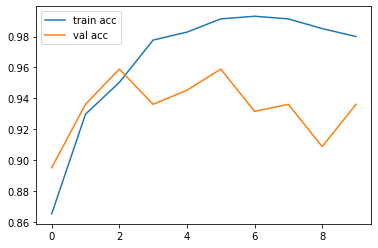

In [61]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

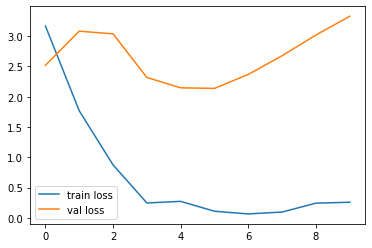

In [62]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [63]:
model.evaluate(test_x,test_y,batch_size=32)

7/7 [==============================] - 154s 21s/step - loss: 2.7212 - accuracy: 0.9591


[2.721240520477295, 0.9590908885002136]

In [64]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

#get confusion matrix
print(confusion_matrix(y_pred,test_y))

7/7 [==============================] - 144s 21s/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        77
           1       0.95      0.96      0.95        72
           2       0.93      0.99      0.96        71

    accuracy                           0.96       220
   macro avg       0.96      0.96      0.96       220
weighted avg       0.96      0.96      0.96       220

[[72  3  2]
 [ 0 69  3]
 [ 0  1 70]]
